In [ ]:
#Created on 1 June 2022
#Last Modified on 19 July 2022
#FYP for Mr. Tian Kai Wen TP051580
#Computer Science (Intelligent system)
#Asia Pacific University
#Data preprocessing

#The code here is to download dataset from Kaggle and then preprocess the downloaded dataset.
#The preprocessing is to split the video into frame,detect the face, crop the face and then create face cropped video

In [ ]:
#Install and import libraries
!pip3 install face_recognition
!pip install -q kaggle
import json
import glob 
import numpy as np
import cv2
import copy
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import matplotlib.pyplot as plt
import face_recognition
from tqdm.autonotebook import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=8d16540c5262af65ff1f375c858e3b3be828338d5ca5571177b2a7577cac2c7e
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kelvintian","key":"d9b020b7a9618ad995ffb44ab772e8e2"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c deepfake-detection-challenge

100% 4.12G/4.13G [00:40<00:00, 121MB/s] 
100% 4.13G/4.13G [00:40<00:00, 110MB/s]


In [ ]:
!unzip deepfake-detection-challenge.zip

Archive:  deepfake-detection-challenge.zip
  inflating: sample_submission.csv   
  inflating: test_videos/aassnaulhq.mp4  
  inflating: test_videos/aayfryxljh.mp4  
  inflating: test_videos/acazlolrpz.mp4  
  inflating: test_videos/adohdulfwb.mp4  
  inflating: test_videos/ahjnxtiamx.mp4  
  inflating: test_videos/ajiyrjfyzp.mp4  
  inflating: test_videos/aktnlyqpah.mp4  
  inflating: test_videos/alrtntfxtd.mp4  
  inflating: test_videos/aomqqjipcp.mp4  
  inflating: test_videos/apedduehoy.mp4  
  inflating: test_videos/apvzjkvnwn.mp4  
  inflating: test_videos/aqrsylrzgi.mp4  
  inflating: test_videos/axfhbpkdlc.mp4  
  inflating: test_videos/ayipraspbn.mp4  
  inflating: test_videos/bcbqxhziqz.mp4  
  inflating: test_videos/bcvheslzrq.mp4  
  inflating: test_videos/bdshuoldwx.mp4  
  inflating: test_videos/bfdopzvxbi.mp4  
  inflating: test_videos/bfjsthfhbd.mp4  
  inflating: test_videos/bjyaxvggle.mp4  
  inflating: test_videos/bkcyglmfci.mp4  
  inflating: test_videos/bktkwbcawi.m

In [ ]:
#Get the frame count of each video
videoDirectory= glob.glob('/content/train_sample_videos/*.mp4')
for v in videoDirectory:
  cap=cv2.VideoCapture(v)
  length=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(length)

300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
298
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
298
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
298
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
298
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
298
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
298
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
298
300
300
300


FAKE    323
REAL     77
Name: label, dtype: int64

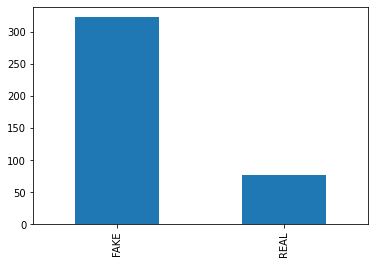

In [ ]:
dfTrain = pd.read_json('/content/train_sample_videos/metadata.json').transpose()
dfTrain.head()
dfTrain.label.value_counts().plot.bar()
dfTrain.label.value_counts()

In [ ]:
#Extract frame
def frameExtract(path):
  vidObj = cv2.VideoCapture(path) 
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image
!mkdir '/content/FaceData'

#Create Face video by extracting frames of video that contain face.
def createFaceVideo(pathList,outDir):
  videoPresent =  glob.glob(outDir+'*.mp4')
  print("No of videos already present " , len(videoPresent))
  for path in tqdm(pathList):
    outPath = os.path.join(outDir,path.split('/')[-1])
    file_exists = glob.glob(outPath)
    if(len(file_exists) != 0):
      print("File Already exists: " , outPath)
      continue
    frames = []
    out = cv2.VideoWriter(outPath,cv2.VideoWriter_fourcc('M','J','P','G'), 30, (112,112))
    for idx,frame in enumerate(frameExtract(path)):
      if(idx <= 150):
        frames.append(frame)
        if(len(frames) == 4):
          faces = face_recognition.batch_face_locations(frames)
          for i,face in enumerate(faces):
            if(len(face) != 0):
              top,right,bottom,left = face[0]
            try:
              out.write(cv2.resize(frames[i][top:bottom,left:right,:],(112,112)))
            except:
              pass
          frames = []
    try:
      del top,right,bottom,left
    except:
      pass
    out.release()

In [ ]:
createFaceVideo(videoDirectory,'/content/FaceData')
!zip -r /content/file.zip /content/FaceData
from google.colab import files
files.download("/content/file.zip")